In [1]:
import pandas as pd 
import numpy as np 
import random

In [2]:
df = pd.read_csv("Only_Description_Sentences.csv")
df

,RequisitionID,CleanedJobTitle,EditedJobDescription
0,00000224907,Guidance Navigation Control GNC Engineer Lead,"{""description"": [""Selected candidates work wid..."
1,00000331804,Propulsion Engineer Associate MidLevel Experie...,"{""description"": [""core organization supports p..."
2,00000336462,Senior Process Controls Engineer,"{""description"": [""As Senior Process Controls E..."
3,00000338951,RFMicrowave Engineer Level,"{""description"": [""Performs trade studies model..."
4,00000339390,Interior Stress Analysis Engineer Career Expert,"{""description"": [""This position must meet Expo..."
...,...,...,...
18530,01.01.16-2023-21,Computer Engineer,"{""description"": [""Dynetics wholly owned subsid..."
18531,334701,Multivendor Customer Service Engineer MIUS Phi...,"{""description"": [""Siemens Healthineers continu..."
18532,R2028871,Engineer,"{""description"": [""The EngineerOperator respons..."
18533,2023-30496,Engineer,"{""description"": [""Pyramid Global Hospitality o..."


In [3]:
df = df[df['EditedJobDescription'].apply(lambda x: isinstance(x, str))]
df

,RequisitionID,CleanedJobTitle,EditedJobDescription
0,00000224907,Guidance Navigation Control GNC Engineer Lead,"{""description"": [""Selected candidates work wid..."
1,00000331804,Propulsion Engineer Associate MidLevel Experie...,"{""description"": [""core organization supports p..."
2,00000336462,Senior Process Controls Engineer,"{""description"": [""As Senior Process Controls E..."
3,00000338951,RFMicrowave Engineer Level,"{""description"": [""Performs trade studies model..."
4,00000339390,Interior Stress Analysis Engineer Career Expert,"{""description"": [""This position must meet Expo..."
...,...,...,...
18530,01.01.16-2023-21,Computer Engineer,"{""description"": [""Dynetics wholly owned subsid..."
18531,334701,Multivendor Customer Service Engineer MIUS Phi...,"{""description"": [""Siemens Healthineers continu..."
18532,R2028871,Engineer,"{""description"": [""The EngineerOperator respons..."
18533,2023-30496,Engineer,"{""description"": [""Pyramid Global Hospitality o..."


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans 
from sklearn.metrics import adjusted_rand_score
import string 
from nltk.corpus import stopwords 
import json
import glob 
import re

In [5]:
descriptions = df["EditedJobDescription"]
descriptions[0]

'{"description": ["Selected candidates work wide range programs provide state art Guidance Navigation Control GNC performance analysis simulation solutions customers.", "Position Responsibilities Define Guidance Navigation Control GNC mission trajectory requirements ensure requirements traceability quality system level component level Design analyze guide others development Guidance Navigation Control GNC systems simulations models tools Lead trade studies offer guidance expertise identify design solutions meet program requirements Lead design reviews analyses simulations componentsystem testing ensure delivery products meet exceed customer requirements expectations Work minimal supervision."]}'

In [6]:
names = df["CleanedJobTitle"]
names[0]

'Guidance Navigation Control GNC Engineer Lead'

In [7]:
custom_stop_words = ["responsibilities", "responsible", "requirements", "required", "duties", "to", "the", "engineering", "engineer", "engineers"]
vectorizer = TfidfVectorizer(lowercase = True, 
                             max_features = 100, 
                             max_df = 0.8, 
                             min_df = 5, 
                             ngram_range = (1,3), 
                             stop_words=custom_stop_words + list(set("english"))
                            )

vectors = vectorizer.fit_transform(descriptions)

feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x = 0
    keywords = []
    for word in description:
        if word > 0: 
            keywords.append(feature_names[x])
        x = x + 1
    all_keywords.append(keywords)

In [11]:
true_k = 20

model = KMeans(n_clusters = true_k, init = "k-means++", max_iter = 100, n_init = 1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open ("clustering_results.txt", "w", encoding = "utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster{i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write(' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

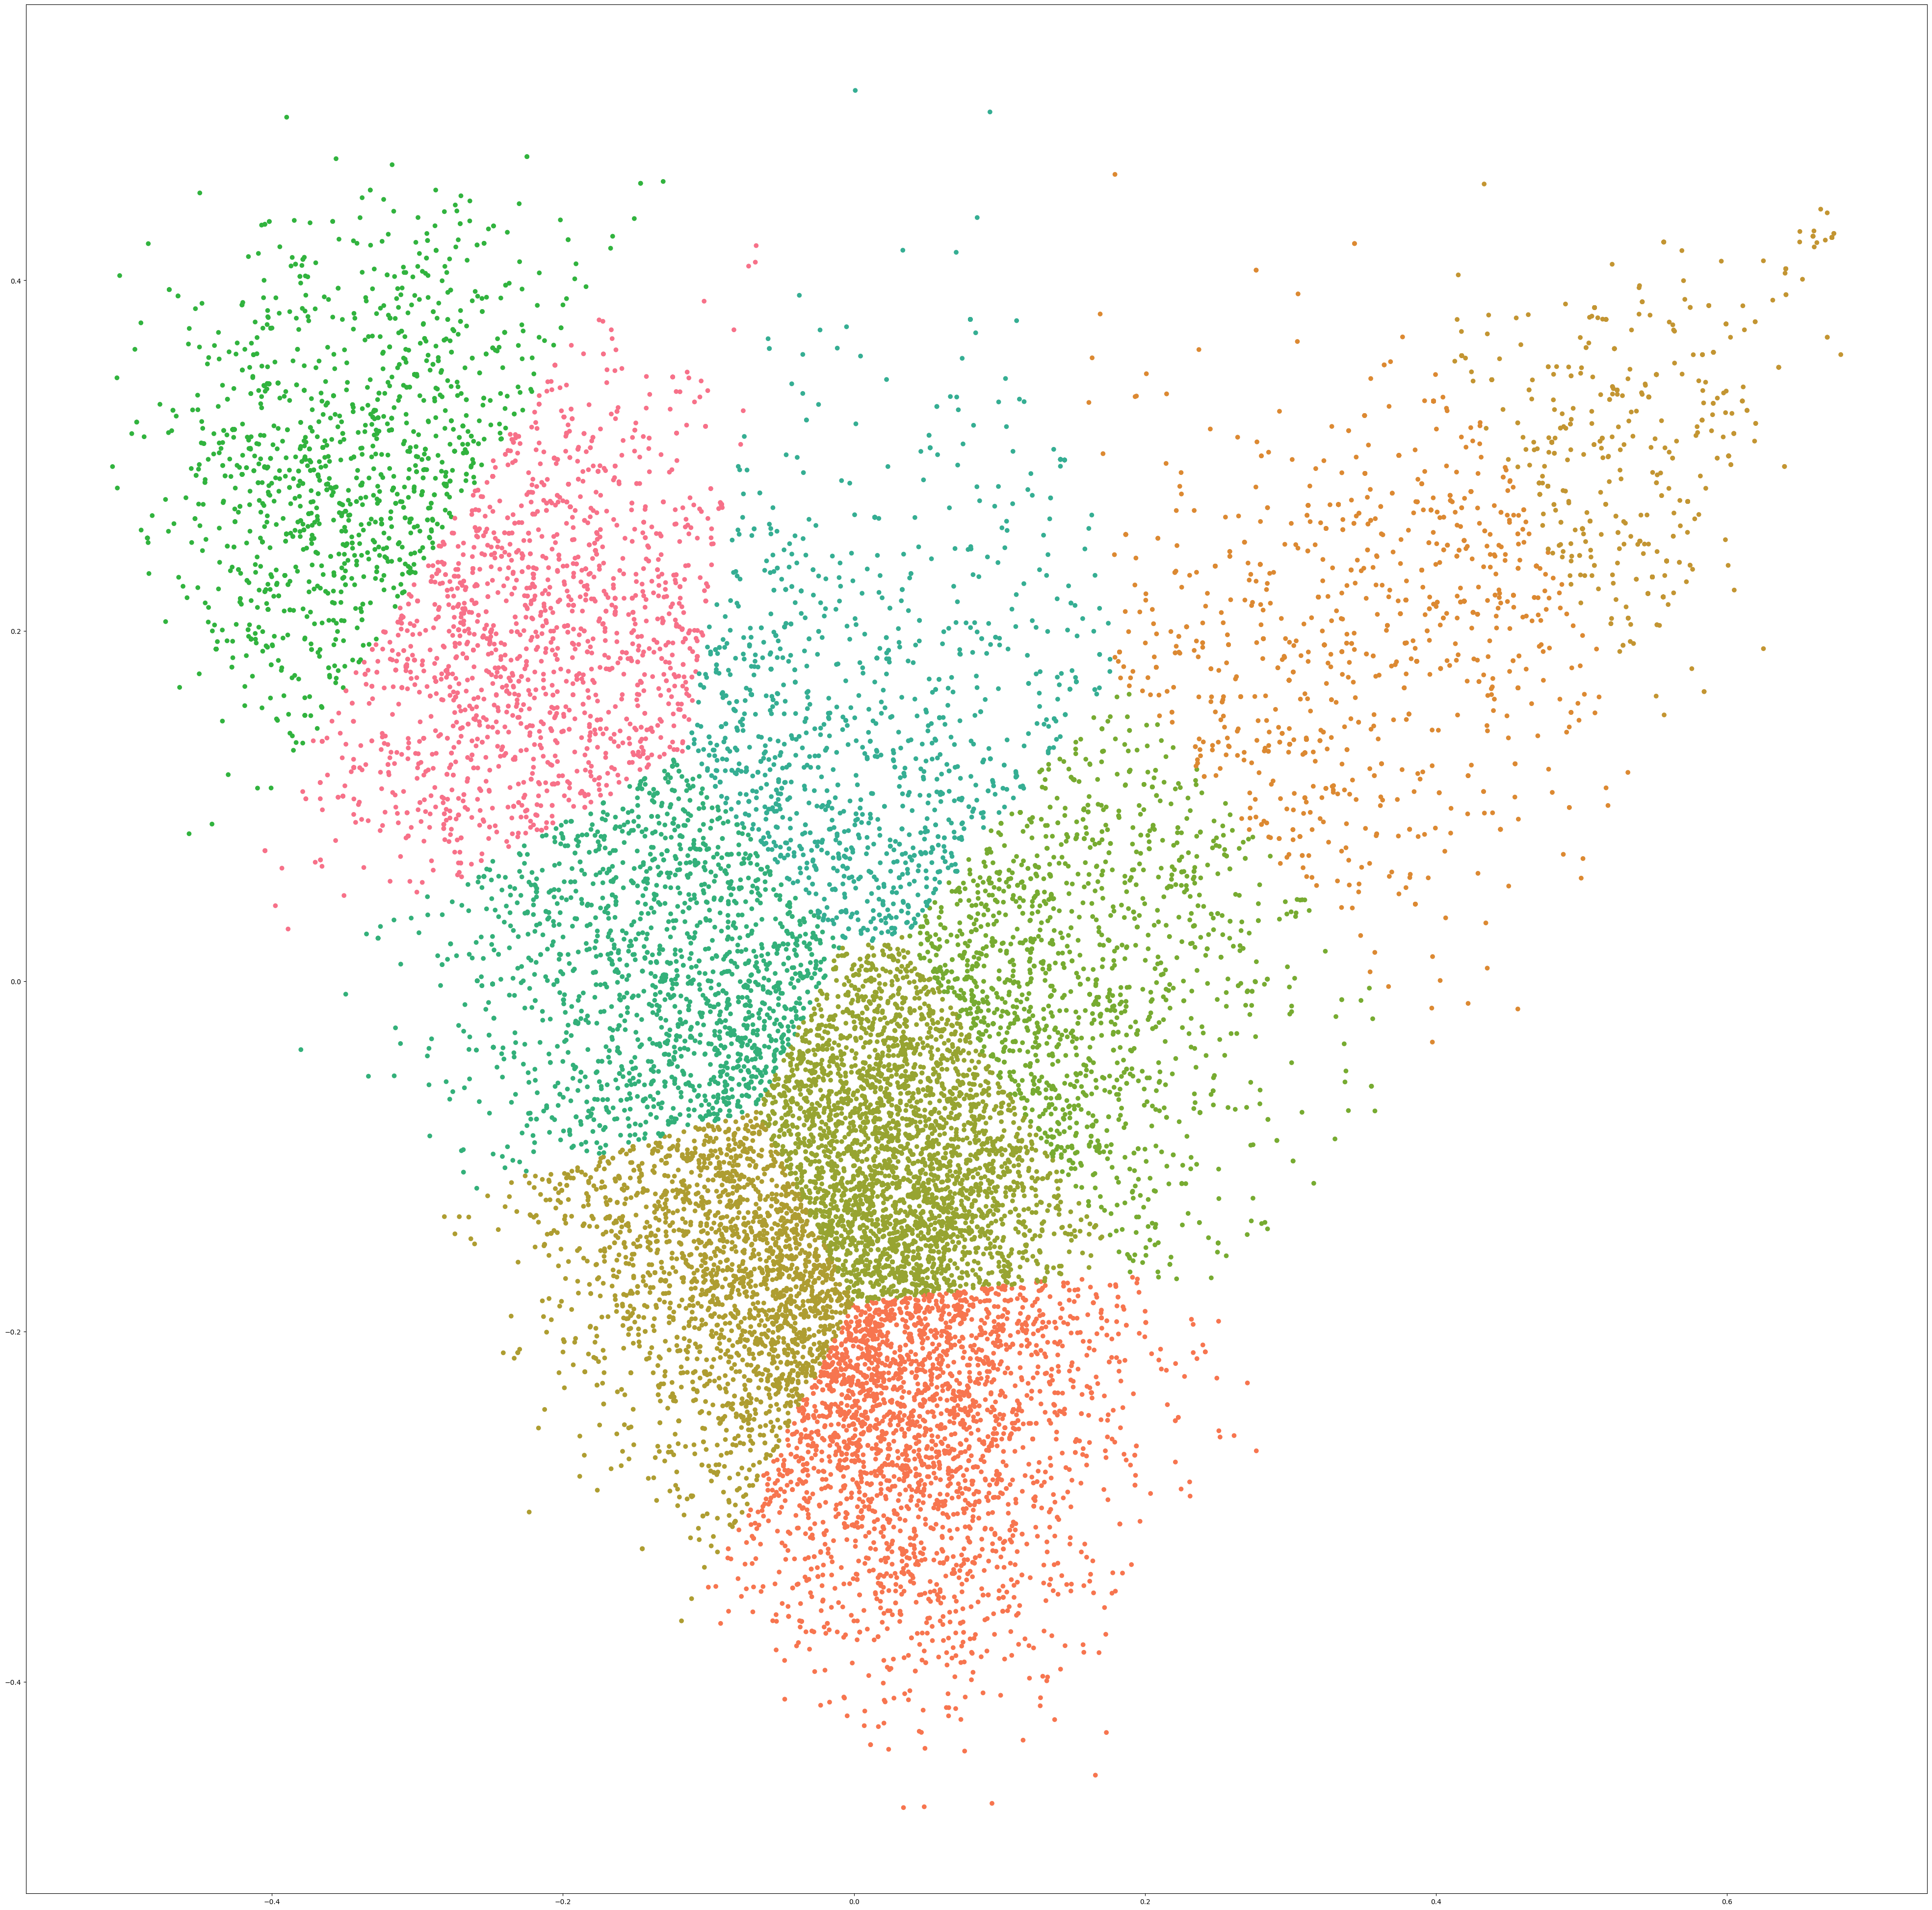

In [13]:
import seaborn as sns

# PCA and K-means clustering
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())
kmean_indices = model.fit_predict(scatter_plot_points)

# Generate 20 distinct colors using Seaborn's "husl" palette
distinct_colors = sns.color_palette("husl", 20)

# Create a dictionary to map cluster numbers to colors
color_map = {cluster_number: color for cluster_number, color in enumerate(distinct_colors)}

def rgb_to_hex(rgb):
    r, g, b = [int(x * 255) for x in rgb]
    return f"#{r:02x}{g:02x}{b:02x}"

# Write to clustering_results.color.txt
with open("clustering_results.color.txt", "w") as f:
    for cluster_number, color in color_map.items():
        color_hex = rgb_to_hex(color)
        f.write(f"Cluster {cluster_number}: Color {color_hex}\n")

# Scatter plot
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
color_list = [color_map[d] for d in kmean_indices]

fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(x_axis, y_axis, c=color_list)

# for i, txt in enumerate(names):
#     ax.annotate(txt[0:20], (x_axis[i], y_axis[i]))

plt.savefig("cluster_plots.png")
